In [1]:
import numpy as np
import pandas as pd
import os
import argparse
import errno
import scipy.misc
import dlib
import cv2
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import sklearn
import time

In [2]:
print( "preparing")
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
original_labels = [0, 1, 2, 3, 4, 5, 6]


preparing


In [3]:
def get_landmarks(image, rects):
    # this function have been copied from http://bit.ly/2cj7Fpq
    if len(rects) > 1:
        raise BaseException("TooManyFaces")
    if len(rects) == 0:
        raise BaseException("NoFaces")
    return np.matrix([[p.x, p.y] for p in predictor(image, rects[0]).parts()])

In [4]:
SELECTED_LABELS = [0,1,2,3,4,5,6]
new_labels = list(set(original_labels) & set(SELECTED_LABELS))
nb_images_per_label = list(np.zeros(len(new_labels), 'uint8'))
def get_new_label(label, one_hot_encoding=False):
    if one_hot_encoding:
        new_label = new_labels.index(label)
        label = list(np.zeros(len(new_labels), 'uint8'))
        label[new_label] = 1
        return label
    else:
        return new_labels.index(label)

In [2]:
print( "importing csv file")
data = pd.read_csv('fer2013.csv')
print("done")
print("Total number of samples: ", len(data))
data.head()

importing csv file
done
Total number of samples:  35887


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
subset_df = data['pixels'].apply(lambda pixel_str: np.fromstring(pixel_str, sep=' '))
subset_df = pd.DataFrame(subset_df)

In [4]:
subset_df = pd.concat([subset_df, data['Usage'], data['emotion']], axis = 1)
subset_df.head()

,pixels,Usage,emotion
0,"[70.0, 80.0, 82.0, 72.0, 58.0, 58.0, 60.0, 63....",Training,0
1,"[151.0, 150.0, 147.0, 155.0, 148.0, 133.0, 111...",Training,0
2,"[231.0, 212.0, 156.0, 164.0, 174.0, 138.0, 161...",Training,2
3,"[24.0, 32.0, 36.0, 30.0, 32.0, 23.0, 19.0, 20....",Training,4
4,"[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Training,6


In [5]:
x = np.vstack(subset_df['pixels'].values)
x = pd.DataFrame(x)
x.head()

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,70.0,80.0,82.0,72.0,58.0,58.0,60.0,63.0,54.0,58.0,...,159.0,182.0,183.0,136.0,106.0,116.0,95.0,106.0,109.0,82.0
1,151.0,150.0,147.0,155.0,148.0,133.0,111.0,140.0,170.0,174.0,...,105.0,108.0,95.0,108.0,102.0,67.0,171.0,193.0,183.0,184.0
2,231.0,212.0,156.0,164.0,174.0,138.0,161.0,173.0,182.0,200.0,...,104.0,138.0,152.0,122.0,114.0,101.0,97.0,88.0,110.0,152.0
3,24.0,32.0,36.0,30.0,32.0,23.0,19.0,20.0,30.0,41.0,...,174.0,126.0,132.0,132.0,133.0,136.0,139.0,142.0,143.0,142.0
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,34.0,31.0,31.0,31.0,27.0,31.0,30.0,29.0,30.0


In [6]:
x = pd.concat([x, subset_df['Usage'],  subset_df['emotion']], axis = 1)
x.head()

,0,1,2,3,4,5,6,7,8,9,...,2296,2297,2298,2299,2300,2301,2302,2303,Usage,emotion
0,70.0,80.0,82.0,72.0,58.0,58.0,60.0,63.0,54.0,58.0,...,183.0,136.0,106.0,116.0,95.0,106.0,109.0,82.0,Training,0
1,151.0,150.0,147.0,155.0,148.0,133.0,111.0,140.0,170.0,174.0,...,95.0,108.0,102.0,67.0,171.0,193.0,183.0,184.0,Training,0
2,231.0,212.0,156.0,164.0,174.0,138.0,161.0,173.0,182.0,200.0,...,152.0,122.0,114.0,101.0,97.0,88.0,110.0,152.0,Training,2
3,24.0,32.0,36.0,30.0,32.0,23.0,19.0,20.0,30.0,41.0,...,132.0,132.0,133.0,136.0,139.0,142.0,143.0,142.0,Training,4
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,31.0,31.0,31.0,27.0,31.0,30.0,29.0,30.0,Training,6


In [7]:
x_train = x[x["Usage"] == 'Training']
x_valid = x[x["Usage"] == 'PublicTest']
x_test = x[x["Usage"] == 'PrivateTest']
y_train = x_train['emotion']
y_valid = x_valid['emotion']
y_test = x_test['emotion']
del x_train['emotion']
del x_valid['emotion']
del x_test['emotion']
del x_train['Usage']
del x_valid['Usage']
del x_test['Usage']

In [8]:
print( "building model...")
from joblib import load
#model = SVC(random_state=42, max_iter=10000, kernel='linear', gamma=0.0001, decision_function_shape = 'ovr')
model = load('raw_pixel_svm.joblib')
print("done")


building model...
done


In [52]:
print("Training on Raw Pixel Data")
start_time = time.time()
model.fit(x_train, y_train)
training_time = time.time() - start_time
print( "training time = {0:.1f} sec".format(training_time))

Training on Raw Pixel Data
training time = 3000.0 sec


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [57]:
validation_accuracy = evaluate(model, x_valid, y_valid)
print( "  - validation accuracy = {0:.1f}".format(validation_accuracy*100))

  - validation accuracy = 22.0


In [58]:
test_accuracy = evaluate(model, x_test, y_test)
print( "  - test accuracy = {0:.1f}".format(test_accuracy*100))

  - test accuracy = 21.6


In [13]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=3)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


In [14]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig = plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    return fig

In [9]:
print("Predicting")
y_predicted_labels = model.predict(x_test)
print("Prediction done")
print("Constructing the confusion matrix")


Predicting
Prediction done
Constructing the confusion matrix


In [60]:
from joblib import dump, load
dump(model, 'raw_pixel_svm.joblib') 


['raw_pixel_svm.joblib']

Normalized confusion matrix
[[0.15 0.03 0.18 0.2  0.21 0.04 0.18]
 [0.05 0.24 0.09 0.18 0.27 0.05 0.11]
 [0.1  0.04 0.18 0.28 0.16 0.07 0.17]
 [0.11 0.03 0.15 0.3  0.2  0.06 0.14]
 [0.1  0.03 0.21 0.22 0.23 0.06 0.16]
 [0.09 0.03 0.13 0.33 0.14 0.15 0.13]
 [0.09 0.03 0.18 0.2  0.23 0.06 0.22]]


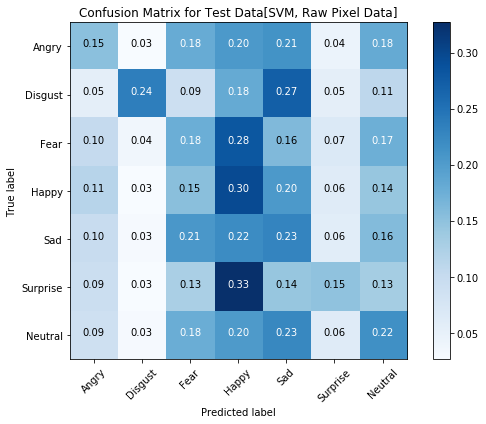

In [15]:
cnf_matrix = sklearn.metrics.confusion_matrix(y_test, y_predicted_labels)
np.set_printoptions(precision=2)
labels=["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
# Plot non-normalized confusion matrix
fig = plot_confusion_matrix(cnf_matrix, classes=labels,
                                     title='Confusion Matrix for Test Data[SVM, Raw Pixel Data]', normalize=True)
plt.show()
fig.savefig('confusion_matrix_svm_raw_pixel_1.png')

In [6]:
print(data['Usage'].unique())
image_height = 48
image_width = 48
window_size = 24
window_step = 6

for category in data['Usage'].unique():
    print( "converting set: " + category + "...")
    if not os.path.exists(category):
        try:
            os.makedirs(category)
        except OSError as e:
            print("error!: ", e)
    
    # get samples and labels of the actual category
    category_data = data[data['Usage'] == category]
    samples = category_data['pixels'].values
    labels = category_data['emotion'].values
    
    # get images and extract features
    images = []
    labels_list = []
    landmarks = []
    hog_features = []
    hog_images = []
    
    for i in range(len(samples)):
        try:
            image = np.fromstring(samples[i], dtype=int, sep=" ").reshape((image_height, image_width))
            images.append(image)
            scipy.misc.imsave('temp.jpg', image)
            image2 = cv2.imread('temp.jpg')
            
            '''Extracting face landmarks here'''
            face_rects = [dlib.rectangle(left=1, top=1, right=47, bottom=47)]
            face_landmarks = get_landmarks(image2, face_rects)
            landmarks.append(face_landmarks) 
            labels_list.append(get_new_label(labels[i], one_hot_encoding=True))
            nb_images_per_label[get_new_label(labels[i])] += 1
            
            features, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                                            cells_per_block=(1, 1), visualise=True)
            hog_features.append(features)
            hog_images.append(hog_image)
        except Exception as e:
            print( "error in image: " + str(i) + " - " + str(e))
    
    np.save("./"+category+'/images.npy', images)
    np.save("./"+category+'/landmarks.npy', landmarks)
    np.save("./"+category+'/labels.npy', labels_list)
    np.save("./"+category+'/hog_features.npy', hog_features)
    np.save("./"+category+'/hog_images.npy', hog_images)

['Training' 'PublicTest' 'PrivateTest']
converting set: Training...


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:31: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


converting set: PublicTest...
converting set: PrivateTest...


In [6]:
data_dict = dict()
validation_dict = dict()
test_dict = dict()

In [8]:
data_dict['X'] = np.load('./Training' + '/landmarks.npy')
data_dict['X'] = np.array([x.flatten() for x in data_dict['X']])
data_dict['X'] = np.concatenate((data_dict['X'], np.load('./Training' + '/hog_features.npy')), axis=1)

In [9]:
print("Total number of training samples: ", len(data_dict['X']))

Total number of training samples:  28709


In [11]:
data_dict['Y'] = np.load('./Training' +  '/labels.npy')

In [11]:
validation_dict['X'] = np.load('./PublicTest' + '/landmarks.npy')
validation_dict['X'] = np.array([x.flatten() for x in validation_dict['X']])
validation_dict['Y'] = np.load('./PublicTest'  + '/labels.npy')
validation_dict['X'] = np.concatenate((validation_dict['X'], np.load('./PublicTest' + '/hog_features.npy')), axis=1)

In [12]:
print("Total number of training samples: ", len(validation_dict['X']))

Total number of training samples:  3589


In [23]:
test_dict['X'] = np.load('./PrivateTest' + '/landmarks.npy')
test_dict['X'] = np.array([x.flatten() for x in test_dict['X']])
test_dict['Y'] = np.load('./PrivateTest'  + '/labels.npy')
test_dict['X'] = np.concatenate((test_dict['X'], np.load('./PrivateTest' + '/hog_features.npy')), axis=1)

In [14]:
print("Number of samples: ", len(test_dict['X']))

Number of samples:  3589


In [8]:
print( "building model...")
model = SVC(random_state=42, max_iter=10000, kernel='rbf', gamma=0.0001, decision_function_shape = 'ovr')
print("done")

building model...
done


In [12]:
print("Getting targets")
dict_y=np.ndarray(len(data_dict['Y']))
count=0
for row in range(len(data_dict['Y'])):
    temp = data_dict['Y'][row][0]
    dict_y[count] = temp
    count+=1
print("Done")

Getting targets
Done


In [ ]:
print("Training - with Face Landmarks and HOG Features")
start_time = time.time()
model.fit(data_dict['X'], dict_y)
training_time = time.time() - start_time
print( "training time = {0:.1f} sec".format(training_time))

In [13]:
def evaluate(model, X, Y):
    predicted_Y = model.predict(X)
    accuracy = accuracy_score(Y, predicted_Y)
    return accuracy


In [14]:
y_df = pd.DataFrame(dict_y)
y_df.head()

,0
0,1.0
1,1.0
2,0.0
3,0.0
4,0.0


In [19]:
dict_v=np.ndarray(len(validation_dict['Y']))
count=0
for row in range(len(validation_dict['Y'])):
    temp = validation_dict['Y'][row][0]
    dict_v[count] = temp
    count+=1

In [20]:
validation_accuracy = evaluate(model, validation_dict['X'], dict_v)
print( "  - validation accuracy = {0:.1f}".format(validation_accuracy*100))

  - validation accuracy = 87.0


In [27]:
dict_t=np.ndarray(len(test_dict['Y']))
count=0
for row in range(len(test_dict['Y'])):
    temp = test_dict['Y'][row][0]
    dict_t[count] = temp
    count+=1

In [28]:
test_accuracy = evaluate(model, test_dict['X'], dict_t)
print( "  - test accuracy = {0:.1f}".format(test_accuracy*100))

  - test accuracy = 86.3


In [7]:
'''Using ONLY HOG features'''
data_hog_train = np.load('./Training' + '/hog_features.npy')

In [48]:
start_time = time.time()
model.fit(data_hog_train, dict_y)
training_time = time.time() - start_time
print( "training time = {0:.1f} sec".format(training_time))

training time = 34.6 sec


In [49]:
y_predicted_labels = model.predict(data_test_hog)

Normalized confusion matrix
[[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]


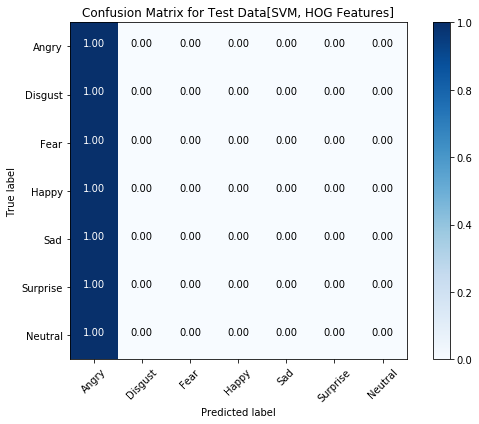

In [50]:
cnf_matrix = sklearn.metrics.confusion_matrix(y_test, y_predicted_labels)
np.set_printoptions(precision=2)
labels=["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
# Plot non-normalized confusion matrix
fig = plot_confusion_matrix(cnf_matrix, classes=labels,
                                     title='Confusion Matrix for Test Data[SVM, HOG Features]', normalize=True)
plt.show()
fig.savefig('confusion_matrix_svm_HOG.png')

In [118]:
data_validation_hog = np.load('./PublicTest' + '/hog_features.npy')
validation_accuracy = evaluate(model, data_validation_hog, dict_v)
print( "  - validation accuracy = {0:.1f}".format(validation_accuracy*100))

  - validation accuracy = 87.0


In [19]:
data_test_hog = np.load('./PrivateTest' + '/hog_features.npy')
test_accuracy = evaluate(model, data_test_hog, dict_t)
print( "  - test accuracy = {0:.1f}".format(test_accuracy*100))

In [40]:
'''Only Face Landmarks'''

data_dict['X'] = np.load('./Training' + '/landmarks.npy')
data_dict['X'] = np.array([x.flatten() for x in data_dict['X']])

validation_dict['X'] = np.load('./PublicTest' + '/landmarks.npy')
validation_dict['X'] = np.array([x.flatten() for x in validation_dict['X']])

test_dict['X'] = np.load('./PrivateTest' + '/landmarks.npy')
test_dict['X'] = np.array([x.flatten() for x in test_dict['X']])

In [41]:
model = SVC(random_state=42, max_iter=10000, kernel='linear', gamma=0.0001, decision_function_shape = 'ovr')

In [42]:
data_dict['Y'] = np.load('./Training' +  '/labels.npy')
dict_y = np.ndarray(len(data_dict['Y']))
count=0
for row in range(len(data_dict['Y'])):
    temp = data_dict['Y'][row][0]
    dict_y[count] = temp
    count+=1

In [43]:
start = time.time()
model.fit(data_dict['X'], dict_y)
training_time = time.time() - start_time
print( "training time = {0:.1f} sec".format(training_time))

training time = 117.1 sec


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [87]:
test_dict['Y'] = np.load('./PrivateTest'  + '/labels.npy')
dict_t=np.ndarray(len(test_dict['Y']))
count=0
for row in range(len(test_dict['Y'])):
    temp = test_dict['Y'][row][0]
    dict_t[count] = temp
    count+=1

In [44]:
print("Prediction begins")
y_predicted_labels = model.predict(test_dict['X'])
print("Prediction complete")

Prediction begins
Prediction complete


Normalized confusion matrix
[[0.42 0.58 0.   0.   0.   0.   0.  ]
 [0.38 0.62 0.   0.   0.   0.   0.  ]
 [0.43 0.57 0.   0.   0.   0.   0.  ]
 [0.44 0.56 0.   0.   0.   0.   0.  ]
 [0.49 0.51 0.   0.   0.   0.   0.  ]
 [0.44 0.56 0.   0.   0.   0.   0.  ]
 [0.48 0.52 0.   0.   0.   0.   0.  ]]


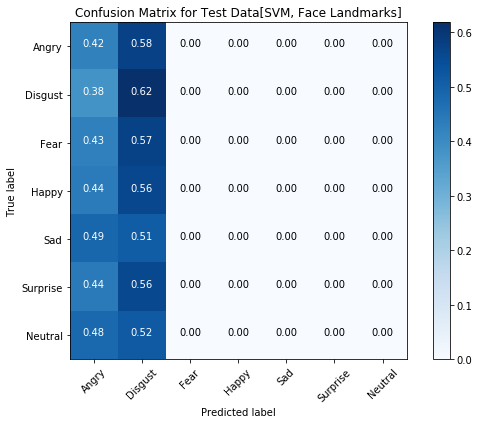

In [46]:
cnf_matrix = sklearn.metrics.confusion_matrix(y_test, y_predicted_labels)
np.set_printoptions(precision=2)
labels=["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
# Plot non-normalized confusion matrix
fig = plot_confusion_matrix(cnf_matrix, classes=labels,
                                     title='Confusion Matrix for Test Data[SVM, Face Landmarks]', normalize=True)
plt.show()
fig.savefig('confusion_matrix_svm_FACE_LANDMARKS.png')

In [92]:
test_accuracy = evaluate(model, test_dict['X'], dict_t)
print("  - test accuracy = {0:.1f}%".format(test_accuracy*100))
print("  - training accuracy:  = {0:.1f}%".format(model.score(data_dict['X'], dict_y)*100))

  - test accuracy = 47.1%
training accuracy:  = 48.0%


In [93]:
validation_dict['Y'] = np.load('./PrivateTest'  + '/labels.npy')
dict_t=np.ndarray(len(validation_dict['Y']))
count=0
for row in range(len(validation_dict['Y'])):
    temp = validation_dict['Y'][row][0]
    dict_t[count] = temp
    count+=1
validation_accuracy = evaluate(model, validation_dict['X'], dict_v)
print("  - validation accuracy = {0:.1f}%".format(validation_accuracy*100))

  - validation accuracy = 48.0%
